In [146]:
from importlib import reload
import game
game = reload(game)
from game import Game
import random
import torch
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import clear_output
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical

import gym
# env = gym.make('CartPole-v0').unwrapped

In [147]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #позволяет перенести тензор на GPU, если он доступен в системе

In [148]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [158]:
def test_agent(env, agent=None, n_episodes=100):
    """Runs agent for n_episodes in environment and calclates mean reward.
    
    Args:
        env: The environment for agent to play in
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.
        n_episodes: Number of episodes to play. Defaults to 100.

    Returns:
        Mean reward for 100 episodes.
    """
    total_reward = []
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        t = 0
        while True:
            if agent:
                with torch.no_grad():
                    probs = agent(torch.FloatTensor(observation).to(device))
                    dist = Categorical(probs)
                    action = dist.sample().item()
            else:
                action = random.randint(0, 1)
            observation, reward, done, _ = env.step(action)
            episode_reward += reward
            t += 1
            if done:
                # print("Episode {} finished after {} timesteps".format(episode+1, t+1))
                break
        total_reward.append(episode_reward)
                   
    return np.mean(total_reward)   

In [150]:
env = Game()
test_agent(env, agent=False, n_episodes=100)

-1.756

In [151]:
class Policy(nn.Module):
    """Policy to be used by agent.

    Attributes:
        state_size: Dimention of the state space of the environment.
        act_size: Dimention of the action space of the environment.
        hidden_size: Dimention of the hidden state of the agent's policy.
    """
    def __init__(self, state_size, act_size, hidden_size, hidden_size2, hidden_size3):
      super(Policy, self).__init__()
      self.act = nn.Sequential(
                                nn.Linear(state_size, hidden_size),
                                nn.ReLU(inplace=True),
                                nn.Linear(hidden_size, hidden_size2),
                                nn.ReLU(inplace=True),
                                nn.Linear(hidden_size2, hidden_size3),
                                nn.ReLU(inplace=True),
                                nn.Linear(hidden_size3, act_size),
                                nn.Softmax(dim=-1)
                               )
    def forward(self, X):
      return self.act(X)

In [152]:
def process_traj_batch(policy, batch, discount):
    """Computes log probabilities for each action 
        and rewards-to-go for each state in the batch of trajectories.
    
    Args:
        policy: Policy of the agent.
        batch (list of list of collections.namedtuple): Batch of trajectories.
        discount (float): Discount factor for rewards-to-go calculation.

    Returns:
        log_probs (list of torch.FloatTensor): List of log probabilities for
            each action in the batch of trajectories.
        returns (list of rewards-to-go): List of rewards-to-go for 
            each state in the batch of trajectories.
    """
    log_probs = []
    returns = []
    
    for episode in batch:
      for numb, step in enumerate(episode):
        returns.append(sum([discount ** i * reward for i, (*_, reward) in enumerate(episode[numb:])]))
        probs = policy(step.state)
        dist = Categorical(probs)
        log_probs.append((dist.log_prob(step.action)))
    return log_probs, returns


In [153]:
STATE_SIZE  = 8 # размерность пространства состояний среды
ACT_SIZE = 3 # размерность пространства действий среды
HIDDEN_SIZE = 200 # размер скрытого слоя для политики
HIDDEN_SIZE2 = 128
HIDDEN_SIZE3 = 64
NUM_EPISODES = 1000 # количество эпиздов, которые будут сыграны для обучения
DISCOUNT = .99 # фактор дисконтирования
TRAIN_EVERY = 20

In [154]:
policy = Policy(STATE_SIZE, ACT_SIZE, HIDDEN_SIZE, HIDDEN_SIZE2, HIDDEN_SIZE3).to(device)
optimizer = Adam(policy.parameters(), lr=1e-2)

In [155]:
transition = collections.namedtuple("transition", ["state", "action", "reward"])

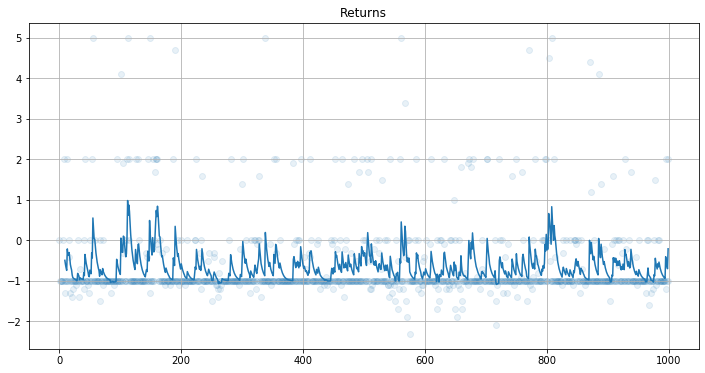

In [156]:
returns_history = []
traj_batch = []
done=False
# env = Game()
best_model = None
best_rewards = 0

for i in range(NUM_EPISODES):
  state = env.reset()
  traj=[]
  rewards=0
  while not done:
      state = torch.FloatTensor(state).to(device)
      probs = policy.forward(state)
      dist = Categorical(probs)
      action = dist.sample()
      previos_state = state
      state, reward, done, _ = env.step(action.item())
      rewards += reward
      traj.append(transition(previos_state, action, reward))
  done=False
  returns_history.append(rewards)
  if rewards >= best_rewards:
      best_model = policy
      best_rewards = rewards
  traj_batch.append(traj)

  if i % TRAIN_EVERY:
      log_probs, returns = process_traj_batch(policy, traj_batch, DISCOUNT)
      loss = -(torch.stack(log_probs) * torch.FloatTensor(returns).to(device)).sum()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      traj_batch = []

  if i % 10:
      clear_output(True)
      plt.figure(figsize=[12, 6])
      plt.title('Returns'); plt.grid()
      plt.scatter(np.arange(len(returns_history)), returns_history, alpha=0.1)
      plt.plot(moving_average(returns_history, span=10, min_periods=10))
      plt.show()

In [159]:
# env = Game(drawing=True)
test_agent(env, agent=policy, n_episodes=100)

-0.29200000000000004